In [1]:
def wcss(hdu, x, y):
    from astropy import wcs
    from astropy.io import fits
    CARD = [('NAXIS1',hdu['NAXIS1']),('NAXIS2',hdu['NAXIS2']),('BUNIT',hdu['BUNIT']),('CTYPE1',hdu['CTYPE1']),
             ('CTYPE2',hdu['CTYPE2']),('CRVAL1',hdu['CRVAL1']),('CRVAL2',hdu['CRVAL2']),('CRPIX1',hdu['CRPIX1']),
             ('CRPIX2',hdu['CRPIX2']),('CROTA2',hdu['CROTA2']),('CDELT1',hdu['CDELT1']),('CDELT2',hdu['CDELT2'])]
    hdr = fits.Header(cards= CARD)
    w = wcs.WCS(hdr)
    recx, recy = w.wcs_pix2world(x, y ,0)
    return [recx, recy]

In [2]:
def wcss2(hdu):
    from astropy import wcs
    from astropy.io import fits
    CARD = [('NAXIS1',hdu['NAXIS1']),('NAXIS2',hdu['NAXIS2']),('BUNIT',hdu['BUNIT']),('CTYPE1',hdu['CTYPE1']),
             ('CTYPE2',hdu['CTYPE2']),('CRVAL1',hdu['CRVAL1']),('CRVAL2',hdu['CRVAL2']),('CRPIX1',hdu['CRPIX1']),
             ('CRPIX2',hdu['CRPIX2']),('CROTA2',hdu['CROTA2']),('CDELT1',hdu['CDELT1']),('CDELT2',hdu['CDELT2'])]
    hdr = fits.Header(cards= CARD)
    w = wcs.WCS(hdr)
    x = hdu['NAXIS1']
    y = hdu['NAXIS2']
    recx, recy = w.wcs_pix2world([1, x, x, 1, 1],[1, 1, y, y, 1],1)
    return [recx, recy]

In [3]:
def wcss3(hdu, x, y):
    from astropy import wcs
    from astropy.io import fits
    CARD = [('NAXIS1',hdu['NAXIS1']),('NAXIS2',hdu['NAXIS2']),('BUNIT',hdu['BUNIT']),('CTYPE1',hdu['CTYPE1']),
             ('CTYPE2',hdu['CTYPE2']),('CRVAL1',hdu['CRVAL1']),('CRVAL2',hdu['CRVAL2']),('CRPIX1',hdu['CRPIX1']),
             ('CRPIX2',hdu['CRPIX2']),('CROTA2',hdu['CROTA2']),('CDELT1',hdu['CDELT1']),('CDELT2',hdu['CDELT2'])]
    hdr = fits.Header(cards= CARD)
    w = wcs.WCS(hdr)
    recx, recy = w.wcs_world2pix(x, y ,0)
    return [recx, recy]

In [5]:
def Image_Plot(img_name, sn, O2, smin, smax):
    import os
    import numpy as np
    import aplpy
    from astropy import wcs
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from astropy.io import fits
    from astropy.table import Table

    data_mode = ['SL2', 'SL1', 'LL2', 'LL1']
    for name in img_name:
        nnaa = '/Users/zhangl/desktop/SINGS/Ancillaryimg/'+name.split('_')[0]
        nnmm = 'ProjImg_{1}/{0}/'.format(name.split('_')[0],O2)
        aabb = nnmm + '{0}_on2_{0}.fits'.format(O2)
        if(os.path.isfile(aabb)):
            cube = fits.open(aabb)
        else:
            print('No such file:{0}'.format(aabb))
            continue
        flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
        flux_sum = flux.sum(axis=2)
        flux_sum[np.isnan(flux_sum)] = 0
        flux_header = cube[0].header
        crpixx, crpixy = np.where(flux_sum == np.max(flux_sum))
        crval = wcss(flux_header, crpixx, crpixy)

        fig = plt.figure(figsize=[9,9])
        if(os.path.isfile('{0}_{1}.fits'.format(nnaa,name.split('_')[1]))):
            img = aplpy.FITSFigure('{0}_{1}.fits'.format(nnaa,name.split('_')[1]), figure=fig)
            img.add_scalebar(1/60,color='r')
            img.scalebar.set_label('$1\ arcmin$')
        else:
            print('No such file:{0}_{1}.fits'.format(nnaa,name.split('_')[1]))
            continue

        for mode in data_mode:
            file_n = nnmm +'{0}_on2_{1}.fits'.format(mode,O2)
            file_u = nnmm +'{0}_on2_{1}_unc.fits'.format(mode,O2)
            if(os.path.isfile(file_n)):
                cube = fits.open(file_n)
                cube_u = fits.open(file_u)
            else:
                print('No such file:{0}'.format(file_n))
                continue

            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_u = np.transpose(cube_u['PRIMARY'].data, axes=(2, 1, 0))
            flux_header = cube['PRIMARY'].header
            rec = wcss2(flux_header)
            recx, recy = np.array(rec[0]), np.array(rec[1])
            img.show_lines([np.array([recx,recy])],color='r')

            x = [[[],[]],[[],[]],[[],[]],[[],[]]]
            y = [[[],[]],[[],[]],[[],[]],[[],[]]]
            crpix = wcss3(flux_header, crval[0], crval[1])
            mm = [flux_header['NAXIS1'], flux_header['NAXIS2']]
            xx = [int(round(crpix[0][0],0))]
            yy = [int(round(crpix[1][0],0))]
            for i in range(xx[0]-1,-1,-1):
                flux_row = flux[i][yy[0]]
                mask = flux_u[i][yy[0]]!=0
                snr = (flux_row[mask]/flux_u[i][yy[0]][mask]).mean()
                if(np.isnan(flux_row).sum()<1 and snr>sn):
                    x[0][0].append(i)
                    y[0][0].append(yy[0])
                if(np.isnan(flux_row).sum()<1 and snr<sn):
                    x[0][1].append(i)
                    y[0][1].append(yy[0])

            for i in range(xx[0]+1,mm[0],1):
                flux_row = flux[i][yy[0]]
                mask = flux_u[i][yy[0]]!=0
                snr = (flux_row[mask]/flux_u[i][yy[0]][mask]).mean()
                if(np.isnan(flux_row).sum()<1 and snr>sn):
                    x[1][0].append(i)
                    y[1][0].append(yy[0])
                if(np.isnan(flux_row).sum()<1 and snr<sn):
                    x[1][1].append(i)
                    y[1][1].append(yy[0])

            for j in range(yy[0]-1,-1,-1):
                flux_col = flux[xx[0]][j]
                mask = flux_u[xx[0]][j]!=0
                snr = (flux_col[mask]/flux_u[xx[0]][j][mask]).mean()
                if(np.isnan(flux_col).sum()<1 and snr>sn):
                    x[2][0].append(xx[0])
                    y[2][0].append(j)
                if(np.isnan(flux_col).sum()<1 and snr<sn):
                    x[2][1].append(xx[0])
                    y[2][1].append(j)

            for j in range(yy[0]+1,mm[1],1):
                flux_col = flux[xx[0]][j]
                mask = flux_u[xx[0]][j]!=0
                snr = (flux_col[mask]/flux_u[xx[0]][j][mask]).mean()
                if(np.isnan(flux_col).sum()<1 and snr>sn):
                    x[3][0].append(xx[0])
                    y[3][0].append(j)
                if(np.isnan(flux_col).sum()<1 and snr<sn):
                    x[3][1].append(xx[0])
                    y[3][1].append(j)

            if(mode[0:2]=='SL'):
                if(len(x[0][0])>0):
                    rec = wcss(flux_header,x[0][0],y[0][0])
                    img.show_markers(rec[0], rec[1], marker='.', facecolor='c', s=10, edgecolor='none')
                if(len(x[0][1])>0):
                    rec = wcss(flux_header,x[0][1],y[0][1])
                    img.show_markers(rec[0], rec[1], marker='.', facecolor='g', s=10, edgecolor='none')

                if(len(x[1][0])>0):
                    rec = wcss(flux_header,x[1][0],y[1][0])
                    img.show_markers(rec[0], rec[1], marker='.', facecolor='c', s=10, edgecolor='none')
                if(len(x[1][1])>0):
                    rec = wcss(flux_header,x[1][1],y[1][1])
                    img.show_markers(rec[0], rec[1], marker='.', facecolor='g', s=10, edgecolor='none')

        
                if(len(x[2][0])>0):
                    rec = wcss(flux_header,x[2][0],y[2][0])
                    img.show_markers(rec[0], rec[1], marker='.', facecolor='c', s=10, edgecolor='none')
                if(len(x[2][1])>0):
                    rec = wcss(flux_header,x[2][1],y[2][1])
                    img.show_markers(rec[0], rec[1], marker='.', facecolor='g', s=10, edgecolor='none')

                if(len(x[3][0])>0):
                    rec = wcss(flux_header,x[3][0],y[3][0])
                    img.show_markers(rec[0], rec[1], marker='.', facecolor='c', s=10, edgecolor='none')
                if(len(x[3][1])>0):
                    rec = wcss(flux_header,x[3][1],y[3][1])
                    img.show_markers(rec[0], rec[1], marker='.', facecolor='g', s=10, edgecolor='none')

            else:
                if(len(x[0][0])>0):
                    rec = wcss(flux_header,x[0][0],y[0][0])
                    img.show_markers(rec[0], rec[1], marker='.', facecolor='b', s=10, edgecolor='none')
                if(len(x[0][1])>0):
                    rec = wcss(flux_header,x[0][1],y[0][1])
                    img.show_markers(rec[0], rec[1], marker='.', facecolor='m', s=10, edgecolor='none')

                if(len(x[1][0])>0):
                    rec = wcss(flux_header,x[1][0],y[1][0])
                    img.show_markers(rec[0], rec[1], marker='.', facecolor='b', s=10, edgecolor='none')
                if(len(x[1][1])>0):
                    rec = wcss(flux_header,x[1][1],y[1][1])
                    img.show_markers(rec[0], rec[1], marker='.', facecolor='m', s=10, edgecolor='none')

                if(len(x[2][0])>0):
                    rec = wcss(flux_header,x[2][0],y[2][0])
                    img.show_markers(rec[0], rec[1], marker='.', facecolor='b', s=10, edgecolor='none')
                if(len(x[2][1])>0):
                    rec = wcss(flux_header,x[2][1],y[2][1])
                    img.show_markers(rec[0], rec[1], marker='.', facecolor='m', s=10, edgecolor='none')

                if(len(x[3][0])>0):
                    rec = wcss(flux_header,x[3][0],y[3][0])
                    img.show_markers(rec[0], rec[1], marker='.', facecolor='b', s=10, edgecolor='none')
                if(len(x[3][1])>0):
                    rec = wcss(flux_header,x[3][1],y[3][1])
                    img.show_markers(rec[0], rec[1], marker='.', facecolor='m', s=10, edgecolor='none')
#    img.add_label(recx.mean(),recy.mean(),mode.split('_')[2], color = 'y')
#        img.set_title(name.split('_')[0],fontsize=20)

        data = fits.open('{0}_{1}.fits'.format(nnaa,name.split('_')[1]))[0].data
        data[np.isnan(data)] = 0
        data.sort()
        vmax = data[:,-1]
        vmax.sort()
        mask = vmax<3*vmax[:-10].mean()
        vv = vmax[mask].mean()
        print(vv)
        img.show_grayscale(stretch='power', vmin=smin, vmax=smax, invert=True)
        dirs = 'Image_{0}/{1}'.format(O2,name.split('_')[0])
        if(os.path.exists(dirs) != True):
            os.makedirs(dirs)
        fig.savefig(dirs+'/{0}_img.png'.format(name.split('_')[0]))
    return

195.42929


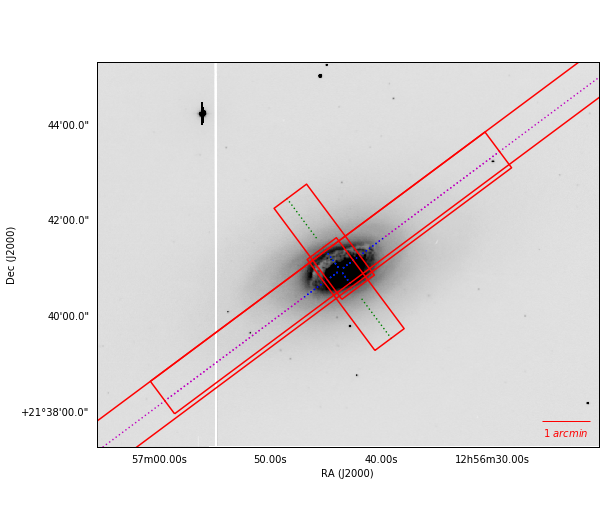

In [7]:
img_name = ['ngc4826_I']

Image_Plot(img_name, 3, 'LL2', 100, 250)

4.2906723


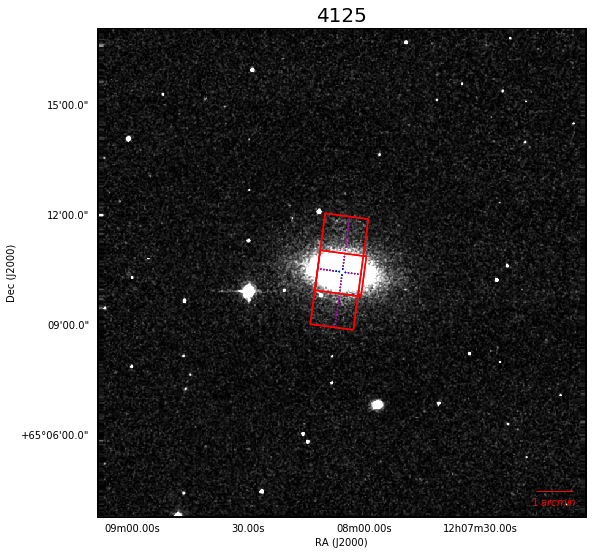

In [8]:
img_name = ['4125_H']

Image_Plot(img_name, 5, 'LL2', -2, 6)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


7.6310225


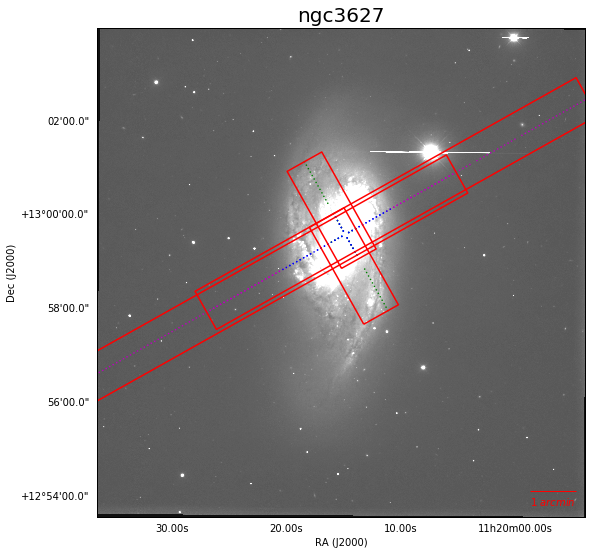

In [117]:
img_name = ['ngc3627_I']

Image_Plot(img_name, 5, 'LL2', -2, 6)

50.04505


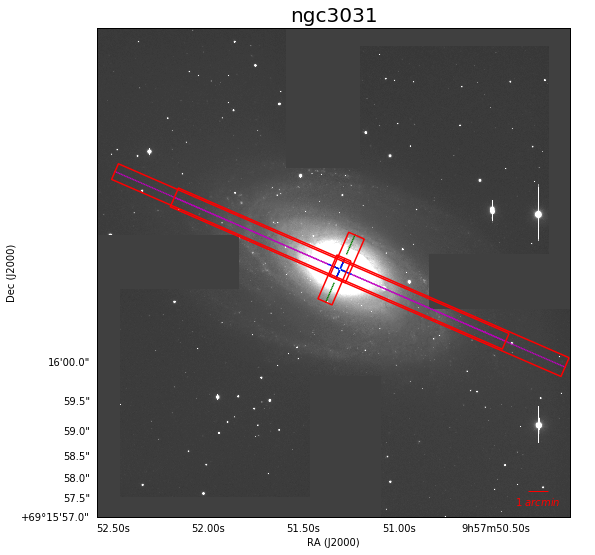

In [90]:
img_name = ['ngc3031_R']

Image_Plot(img_name, 5, 'LL2', -5, 5)

7.7318406


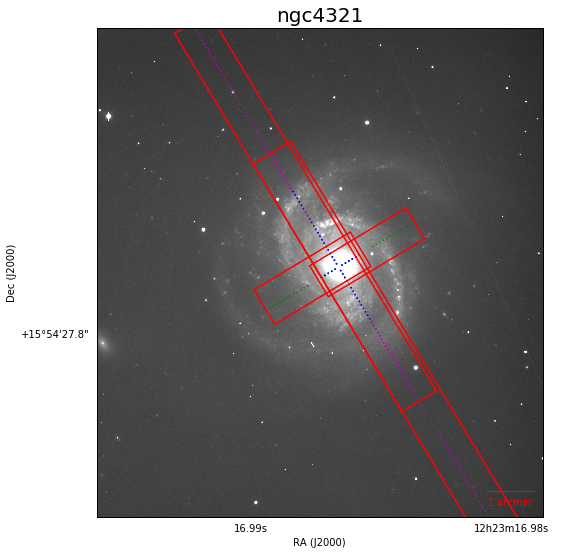

In [14]:
img_name = ['ngc4321_I']

Image_Plot(img_name, 5, 'LL2', 2, 8)

In [15]:
img_name = ['ngc7552_I']

Image_Plot(img_name, 5, 'LL2', -5, 9)

No such file:ProjImg_LL2/ngc7552/LL2_on2_LL2.fits


0.0063333493


/usr/local/lib/python3.6/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


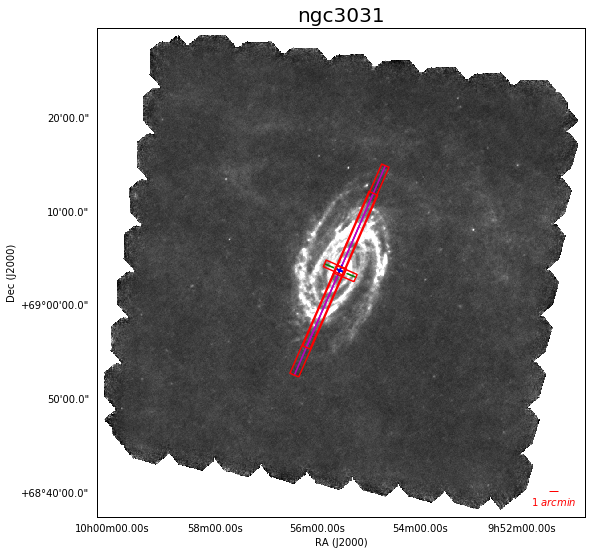

In [86]:
img_name = ['ngc3031_MESSIER-081-I-PACS-160-b2012']

Image_Plot(img_name, 5, 'LL2', -0.009, 0.009)

/usr/local/lib/python3.6/site-packages/aplpy/wcs_util.py:515: UserWarning: Pixels are not square, using an average pixel scale
  warnings.warn("Pixels are not square, using an average pixel scale")


4.7364063


/usr/local/lib/python3.6/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


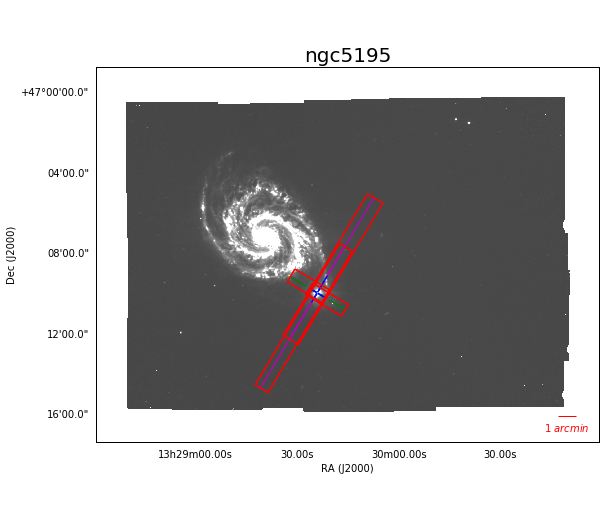

In [82]:
img_name = ['ngc5195_ARP-085-I-IRAC-8.0-ssh2007']

Image_Plot(img_name, 5, 'LL2', -9, 9)